-Amira Kouider 21914040 (MLDS)
-Nadia Radouani 21911973 (MLDS)
-Taous Iggui 21909286 (VMI)
-Ghazeleh Ghanizadeh 21914004 (VMI)

# Netflix Movie Recommendation System

We all wonder how Amazon or Netflix arrived at this "power" and this success? How Netflix Can Know Our Cinematic 
Preferences? How did Amazon know I was a big fan of Games of Thrones ? And how did Youtube know i am interested 
by wildlife documentary ?

Well, this is called Recommendation System.

The main goal of this machine learning project is to build a recommendation engine that recommends movies to users.

We will use  Netflix. It consists of 4 text data files, each file contains over 20M 
rows, i.e. over 4K movies and 400K customers. All together over 17K movies and 500K+ customers!

In order to do this, we have used the Netflix Dataset. This data consists of 4 text data files, each file contains 
over 20M rows. All together 17.770 Movies, 480.189 customers, 100.480.507 ratings given.

Also, "User-based collaborative filtering", a type of recommendation algorithm based on self & others behaviour.

<img src="image.jpg"/>

### Table of Content:

* Data processing
    * Importing Essential Libraries
    * Retrieving the Data
        - Load Data & show theire shapes 
        - Show some information about the Data
    * Data Pre-processing
    * Data slicing
* Recommendation models
    * Collaborative Filtering
        - Prediction
            - Prediction for a user picked randomly
    * Similarities Between Movies (CORRELATION)


## Data processing

### Importing Essential Libraries

In [64]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset, SVD, NormalPredictor,BaselineOnly, SVDpp
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

### Retrieving the Data

Each data file (there are 4 of them) contains the movie id followed by a column.  

Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

CustomerID,Rating,Date

- MovieIDs range from 1 to 17770 sequentially.
- CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
- Ratings are on a five star (integral) scale from 1 to 5.
- Dates have the format YYYY-MM-DD.

#### Load Data & show theire shapes 

Knowing that there is four files

In [65]:
## DATA I
data_1 = pd.read_csv("C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/netflix-prize-data/combined_data_1.txt",
                     header=None,
                     names=["Cust_Id", "Rating"],
                     usecols=[0, 1]
                     )
print("data_1: ", data_1.shape)
data_1['Rating'] = data_1['Rating'].astype(float)

## DATA II
data_2 = pd.read_csv("C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/netflix-prize-data/combined_data_2.txt",
                     header=None,
                     names=["Cust_Id", "Rating"],
                     usecols=[0, 1]
                     )
print("data_2: ", data_2.shape)
data_2['Rating'] = data_2['Rating'].astype(float)

## DATA III
data_3 = pd.read_csv("C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/netflix-prize-data/combined_data_3.txt",
                     header=None,
                     names=["Cust_Id", "Rating"],
                     usecols=[0, 1]
                     )
print("data_3: ", data_3.shape)
data_3['Rating'] = data_3['Rating'].astype(float)

## DATA IV
data_4 = pd.read_csv("C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/netflix-prize-data/combined_data_4.txt",
                     header=None,
                     names=["Cust_Id", "Rating"],
                     usecols=[0, 1]
                     )
print("data_4: ", data_4.shape)
data_4['Rating'] = data_4['Rating'].astype(float)

data_1:  (24058263, 2)
data_2:  (26982302, 2)
data_3:  (22605786, 2)
data_4:  (26851926, 2)


Combine the 4 Data and print the total shape

In [66]:
data = data_1
data = data_1.append(data_2)
data = data.append(data_3)
data = data.append(data_4)

#We will be working with subsets of a DataFrame object, to accomplish this including we will use Data Indexing
data.index = np.arange(0,len(data))

print("Full data: ", data.shape)


Full data:  (100498277, 2)


Now, we will load the file which contains the titles of movies and show part of it

In [4]:
data_movie = pd.read_csv('C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])

#We will use "Movie_Id" as index of a Data_movie
data_movie.set_index('Movie_Id', inplace = True)

print (data_movie.head())

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW


#### Show some information about the Data

Lets get a brief description of our dataset in order to enable us understand the dataset we are working with

In [5]:
data.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [6]:
data.describe()

,Rating
count,1.004805e+08
mean,3.604290e+00
std,1.085219e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


We can see that the average rating is 3.60 and the max is 5. We can also count over 100000000 rating

Now, we will calculate the total of movies, customers and ratings given

In [7]:
# Total movies 
#in order to avoid calculating the NAN values which are in front of each movie_id we use the function isnull()
total_movie = data.isnull().sum()[1]

# Total customer
# To avoid redundancy of customer ID we will use the function "nunique" which returns the total number of unique values
# We should also delete the rows containing the movie ID (in column Cust_Id) which are "total_movie"
total_customer = data['Cust_Id'].nunique() - total_movie

# Total ratings given
# The function "count()" returns how many times a given object occurs in list (ratings given)
total_rating = data['Cust_Id'].count() - total_movie

print("TOTAL : "
      " {:,} Movies,"
      " {:,} customers,"
      " {:,} ratings given.".format(total_movie, total_customer, total_rating))

TOTAL :  17,770 Movies, 480,189 customers, 100,480,507 ratings given.


### Data Pre-processing

Adding the movie ID column into the data will make it so much huge and it won't be clean. So we will create a array using it with correct length then add it to the data.

First lets create a dataframe from data with two colums "Rating" & "Index" using reset_index()(method which sets a list of integer ranging from 0 to length of data as index).

In [8]:
# We will detect the rows (having a nan in the rating column) which correspond to the movies ID, 
#then we will index them and reset the indixation of data_null
data_null = pd.DataFrame(pd.isnull(data.Rating))
data_null = data_null[data_null['Rating'] == True]
data_null = data_null.reset_index()

movie_bis = []
movie_id = 1

for i,j in zip(data_null['index'][1:],data_null['index'][:-1]):
    var = np.full((1,i-j-1), movie_id)
    movie_bis = np.append(movie_bis, var)
    movie_id += 1

# Add the last 
last_one = np.full((1,len(data) - data_null.iloc[-1, 0] - 1),movie_id)
movie_bis = np.append(movie_bis, last_one)

print("movie_bis: ", movie_bis.shape)


movie_bis:  (100480507,)


In [9]:
# remove those Movie ID rows
data = data[pd.notnull(data['Rating'])]

data['Movie_Id'] = movie_bis.astype(int)
data['Cust_Id'] = data['Cust_Id'].astype(int)

# print a part of new Data
print("The new data : " )
data.head()

The new data : 


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


### Data slicing

Now let's take a look at the average rating of each movie. To do so, we will group the dataset by the movie_id and then calculate the mean of the rating for each movie.

In [10]:
data.groupby('Movie_Id')['Rating'].mean().sort_values(ascending=False).head()

Movie_Id
14961    4.723270
7230     4.716611
7057     4.702611
3456     4.670989
9864     4.638809
Name: Rating, dtype: float64

However, there is a problem. A movie can make it to the top of the above list even if only a single user has given it five stars. Therefore, the above stats can be misleading. Normally, a movie which is really a good one gets a higher rating by a large number of users.

Let's now plot the total number of ratings for a movie:

In [11]:
data.groupby('Movie_Id')['Rating'].count().sort_values(ascending=False).head()

Movie_Id
5317     232944
15124    216596
14313    200832
15205    196397
1905     193941
Name: Rating, dtype: int64

Now you can see some really good movies at the top. The above list supports our point that good movies normally receive higher ratings. Now we know that both the average rating per movie and the number of ratings per movie are important attributes.

In [12]:
ratings_mean_count = pd.DataFrame(data.groupby('Movie_Id')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(data.groupby('Movie_Id')['Rating'].count())
ratings_mean_count.head()

,Rating,rating_counts
Movie_Id,,
1,3.749543,547
2,3.558621,145
3,3.641153,2012
4,2.739437,142
5,3.919298,1140


Let's plot a histogram for the number of ratings represented by the "rating_counts" column in the above dataframe.

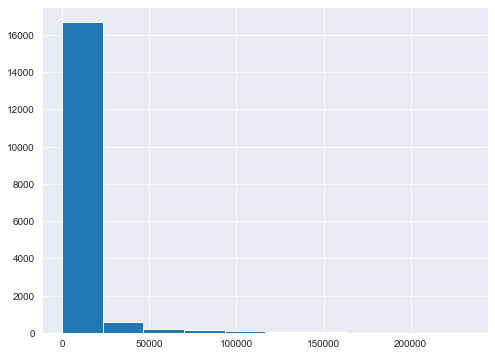

In [13]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist()

From the output, we can see that most of the movies have received less than 25000 ratings. While the number of movies having more than 50000 ratings is very low.

Now we'll plot a histogram for average ratings. Here is the code to do so:

Let's now do the same thing with "Cust_Id"

In [14]:
data.groupby('Cust_Id')['Rating'].count().sort_values(ascending=False).head()

Cust_Id
305344     17653
387418     17436
2439493    16565
1664010    15813
2118461    14831
Name: Rating, dtype: int64

In [15]:
data.groupby('Cust_Id')['Rating'].mean().head()

Cust_Id
6     3.418530
7     4.011351
8     4.214286
10    3.392308
25    3.481481
Name: Rating, dtype: float64

In [16]:
customer_mean_count = pd.DataFrame(data.groupby('Cust_Id')['Rating'].mean())
customer_mean_count['rating_counts'] = pd.DataFrame(data.groupby('Cust_Id')['Rating'].count())
customer_mean_count.head()

,Rating,rating_counts
Cust_Id,,
6,3.418530,626
7,4.011351,881
8,4.214286,98
10,3.392308,260
25,3.481481,27


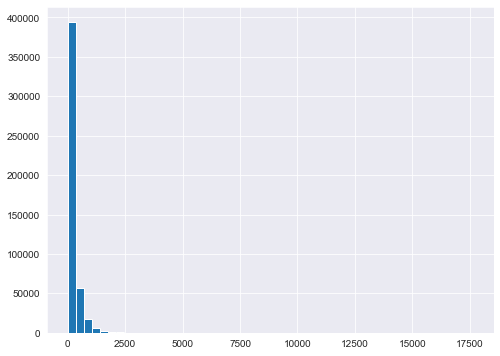

In [17]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
customer_mean_count['rating_counts'].hist(bins=50)

From the output, we can see that most of the customer gave the less ratings (same reasoning as "Movie_Id").

Since the data is super huge, we had many times a memory error, so according to the results shown above, we opted for data reducing by removing :

    *Less reviews movies
    *Customer who give too less ratings

In [18]:
ratings_mean_count.index = ratings_mean_count.index.map(int)
movie_benchmark = round(ratings_mean_count['rating_counts'].quantile(0.7),0)
drop_movie_list = ratings_mean_count[ratings_mean_count['rating_counts'] < movie_benchmark].index

print('Less reviews movies: {}'.format(movie_benchmark))

customer_mean_count.index = customer_mean_count.index.map(int)
cust_benchmark = round(customer_mean_count['rating_counts'].quantile(0.7),0)
drop_cust_list = customer_mean_count[customer_mean_count['rating_counts'] < cust_benchmark].index

print('Customers who give too less ratings: {}'.format(cust_benchmark))

Less reviews movies: 1948.0
Customers who give too less ratings: 211.0


Now, lets compare the sizes of the original data and the new one

In [19]:
print('Original Data: {}'.format(data.shape))
data = data[~data['Movie_Id'].isin(drop_movie_list)]
data = data[~data['Cust_Id'].isin(drop_cust_list)]
print('New Data: {}'.format(data.shape))

Original Data: (100480507, 3)
New Data: (71833509, 3)


## Recommendation models

Our Data is loaded and cleaned, so let's get into the recommendation system.
We will implement a first model called Collaborative Filtering and seconde one based on Pearsons' R correlations.

### User-Based Collaborative Filtering

Collaborative Filtering involves suggesting movies to the users that are based on collecting preferences from many other users. 
For example, if a user A likes to watch action films and so does user B, then the movies that the user B will watch 
in the future will be recommended to A and vice-versa. 
Therefore, recommending movies is dependent on creating a relationship of similarity between the two users. 

We will use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of our chosing. we’ll need to use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset:

In [20]:
# Load the dataset
reader=Reader()
dataBis = Dataset.load_from_df(data[['Cust_Id', 'Movie_Id', 'Rating']][:10000000], reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(dataBis, test_size=.25)

Next, we will build our model using 3 algorithms : SVD, BaselineOnly and NormalPredictor, and compare their RMSE

Let's start with the famous SVD algorithm

In [21]:
# SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
print("The RMSE: ")
accuracy.rmse(predictions)

The RMSE: 
RMSE: 0.8699


0.869895202421739

In [22]:
# BaselineOnly algorithm.
algo_BL = BaselineOnly()

# Train the algorithm on the trainset, and predict ratings for the testset
algo_BL.fit(trainset)
predictions_BL = algo_BL.test(testset)

# Then compute RMSE
print("The RMSE : ")
accuracy.rmse(predictions_BL)

Estimating biases using als...
The RMSE : 
RMSE: 0.9109


0.9108521343261852

In [79]:
# NormalPredictor algorithm.
algo_NP = NormalPredictor()

# Train the algorithm on the trainset, and predict ratings for the testset
algo_NP.fit(trainset)
predictions_NP = algo_NP.test(testset)

# Then compute RMSE
print("The RMSE : ")
accuracy.rmse(predictions_NP)

The RMSE : 
RMSE: 1.4292


1.4291720842960218

According to the results above :

The algorithm with the best performance is SVD which reduced the error (RMSE) to 0.87.

PS : To apply SVD algorithm we had a memory error even when we used just 30000000 rows of our data, so we were obliged to use only 10000000 rows of the data.

So now, we will do the prediction using SVD

#### Prediction

To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.
We will create 2 functions : 

     get_scoreU : takes as arguments Cust_Id and returns the number of movies rated by him (user).
     get_userS : takes as arguements Movie_Id and returns the number of users that have rated its (movie)

In [23]:
def get_scoreU(cid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(cid)])
    except ValueError:  # if user was not part of the trainset
        return 0
    
def get_userS(mid):
    try:
        return len(trainset.ir[trainset.to_inner_iid(mid)])
    except ValueError:  # if item was not part of the trainset
        return 0

In [73]:
 df = pd.DataFrame(predictions, columns=['Cust_Id', 'Movie_Id', 'Rating', 'PRating','details']) 
df['Su'] = df.Cust_Id.apply(get_scoreU)
df['Ms'] = df.Movie_Id.apply(get_userS)
df['err'] = abs(df.PRating - df.Rating)

In [74]:
df.head()

,Cust_Id,Movie_Id,Rating,PRating,details,Su,Ms,err
0,2108785,2452,5.0,4.522368,{'was_impossible': False},53,77393,0.477632
1,1658961,1466,5.0,3.273799,{'was_impossible': False},53,23499,1.726201
2,2273811,1282,2.0,2.075102,{'was_impossible': False},50,1480,0.075102
3,2393992,1066,3.0,3.212307,{'was_impossible': False},28,24470,0.212307
4,1535491,2391,4.0,2.841939,{'was_impossible': False},52,49648,1.158061


In [75]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [76]:
best_predictions

,Cust_Id,Movie_Id,Rating,PRating,details,Su,Ms,err
2142607,626901,577,5.0,5.0,{'was_impossible': False},27,1488,0.0
2365646,496853,1615,5.0,5.0,{'was_impossible': False},47,37721,0.0
1990565,2333692,658,5.0,5.0,{'was_impossible': False},63,30116,0.0
663891,2500476,1625,5.0,5.0,{'was_impossible': False},28,28914,0.0
1381147,2634757,2452,5.0,5.0,{'was_impossible': False},28,77393,0.0
1406494,2531675,2532,5.0,5.0,{'was_impossible': False},69,8084,0.0
351610,1750288,1799,5.0,5.0,{'was_impossible': False},74,38671,0.0
1185464,291503,1220,5.0,5.0,{'was_impossible': False},129,57860,0.0
1052207,1451860,2114,5.0,5.0,{'was_impossible': False},73,6026,0.0
1406496,1451649,1947,5.0,5.0,{'was_impossible': False},42,2815,0.0


The best predictions above are not lucky guesses. Because for every movie in this list the Ms (Number of users that have rated its) isn't small, it's highly enough, this means that significant number of users have rated the movie.

In [77]:
worst_predictions

,Cust_Id,Movie_Id,Rating,PRating,details,Su,Ms,err
1277332,1633216,725,1.0,5.0,{'was_impossible': False},65,2226,4.0
1469819,291407,2551,1.0,5.0,{'was_impossible': False},42,2808,4.0
722850,128372,2372,1.0,5.0,{'was_impossible': False},54,63727,4.0
1275528,942289,1110,1.0,5.0,{'was_impossible': False},21,44753,4.0
2339285,508379,1495,1.0,5.0,{'was_impossible': False},68,9141,4.0
1730884,2447578,270,1.0,5.0,{'was_impossible': False},22,18875,4.0
2181369,2315012,1877,1.0,5.0,{'was_impossible': False},313,17245,4.0
408047,1028463,133,1.0,5.0,{'was_impossible': False},384,1517,4.0
1857344,735560,638,1.0,5.0,{'was_impossible': False},131,2789,4.0
374181,509431,270,1.0,5.0,{'was_impossible': False},22,18875,4.0


The worst predictions look pretty surprise. For example, every movie in this list was given score 5 by the SVD algorithm while it has been rated 1.
From a technical point of vue, this is normal because each prediction algorithm has an error rate that must be taken in to account in the analysis of the results.

##### Prediction for a user picked randomly

Now we will pick a customer Id randomly, we first print list of movies that he liked in the past and then predict which movie he would like to watch.

In [113]:
#Movies liked in the past
df_cust_1664010 = data[(data['Cust_Id'] == 1664010) & (data['Rating'] == 5)]
df_cust_1664010 = df_cust_1664010.set_index('Movie_Id')
df_cust_1664010 = df_cust_1664010.join(data_movie)['Name']
print(df_cust_1664010.head())

Movie_Id
3            Character
16           Screamers
18    Immortal Beloved
26     Never Die Alone
28     Lilo and Stitch
Name: Name, dtype: object


In [114]:
#Function to predict movies that user would like (with rating=5)
def pridect (cid):
    pridect_cust=df[(df['Cust_Id'] == cid) & (df['PRating'] == 5)]
    return((pridect_cust.iloc[:, lambda pridect_cust: [1, 3]]).head())

#For the user "1664010"
pridect (1664010)

,Movie_Id,PRating
75667,2430,5.0
95954,1058,5.0
121592,2525,5.0
156359,751,5.0
162201,2016,5.0


In [115]:
#To go further, we display not only the list with the movie_id but with the titles of the movies too
Z=pridect (1664010)
Z = Z.set_index('Movie_Id')
Z = Z.join(data_movie)['Name']
print(Z)

Movie_Id
2430    Alien: Collector's Edition
1058                 Play it Again
2525            Sullivan's Travels
751                 Halloween: H2O
2016         The Magdalene Sisters
Name: Name, dtype: object


### Item-Based Collaborative Filtering

In this part, we will use the correlation between the ratings of a movie as the similarity metric.

In order to do this, we need to create a matrix where each column is a movie name and each row contains the rating assigned by a specific user to that movie.

Since the data is very big, we had a memory error, so we decided do this part of our project with only the first data, knowing that it contains more than 24 million rows.

First we will clean our data, like we did before with the hall data.

In [9]:
# We will detect the rows (having a nan in the rating column) which correspond to the movies ID, 
#then we will index them and reset the indixation of data_null
data_1_null = pd.DataFrame(pd.isnull(data_1.Rating))
data_1_null = data_1_null[data_1_null['Rating'] == True]
data_1_null = data_1_null.reset_index()

movie_bis = []
movie_id = 1

for i,j in zip(data_1_null['index'][1:],data_1_null['index'][:-1]):
    var = np.full((1,i-j-1), movie_id)
    movie_bis = np.append(movie_bis, var)
    movie_id += 1

# Add the last 
last_one = np.full((1,len(data_1) - data_1_null.iloc[-1, 0] - 1),movie_id)
movie_bis = np.append(movie_bis, last_one)

print("movie_bis: ", movie_bis.shape)

movie_bis:  (24053764,)


In [10]:
# remove those Movie ID rows
data_1 = data_1[pd.notnull(data_1['Rating'])]

data_1['Movie_Id'] = movie_bis.astype(int)
data_1['Cust_Id'] = data_1['Cust_Id'].astype(int)

# print a part of new data_1
print("The new data_1 : " )
data_1.head()

C:\Users\NADIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


The new data_1 : 


C:\Users\NADIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [15]:
data_1.groupby('Movie_Id')['Rating'].mean().sort_values(ascending=False)
data_1.groupby('Movie_Id')['Rating'].count().sort_values(ascending=False)
ratings_mean_count = pd.DataFrame(data_1.groupby('Movie_Id')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(data_1.groupby('Movie_Id')['Rating'].count())
#ratings_mean_count.head()
data_1.groupby('Cust_Id')['Rating'].count().sort_values(ascending=False).head()
data_1.groupby('Cust_Id')['Rating'].mean().head()

Cust_Id
6     3.333333
7     4.066667
8     4.000000
10    3.346939
25    3.500000
Name: Rating, dtype: float64

In [16]:
customer_mean_count = pd.DataFrame(data_1.groupby('Cust_Id')['Rating'].mean())
customer_mean_count['rating_counts'] = pd.DataFrame(data_1.groupby('Cust_Id')['Rating'].count())
customer_mean_count.head()

ratings_mean_count.index = ratings_mean_count.index.map(int)
movie_benchmark = round(ratings_mean_count['rating_counts'].quantile(0.7),0)
drop_movie_list = ratings_mean_count[ratings_mean_count['rating_counts'] < movie_benchmark].index

print('Less reviews movies: {}'.format(movie_benchmark))

Less reviews movies: 1799.0


In [17]:
customer_mean_count.index = customer_mean_count.index.map(int)
cust_benchmark = round(customer_mean_count['rating_counts'].quantile(0.7),0)
drop_cust_list = customer_mean_count[customer_mean_count['rating_counts'] < cust_benchmark].index

print('Customers who give too less ratings: {}'.format(cust_benchmark))

print('Original data_1: {}'.format(data_1.shape))
data_1 = data_1[~data_1['Movie_Id'].isin(drop_movie_list)]
data_1 = data_1[~data_1['Cust_Id'].isin(drop_cust_list)]
print('New data_1: {}'.format(data_1.shape))

Customers who give too less ratings: 52.0
Original data_1: (24053764, 3)
New data_1: (17337458, 3)


Now, we will creat a new data by merging data_1 with data_movie.

In [18]:
data_movie_bis=pd.merge(data_1, data_movie, on='Movie_Id')
data_movie_bis.head()

,Cust_Id,Rating,Movie_Id,Year,Name
0,712664,5.0,3,1997.0,Character
1,1331154,4.0,3,1997.0,Character
2,2632461,3.0,3,1997.0,Character
3,44937,5.0,3,1997.0,Character
4,656399,4.0,3,1997.0,Character


Let's now plot the total number of ratings for a movie:

In [19]:
data_movie_bis.groupby('Name')['Rating'].count().sort_values(ascending=False).head()

Name
Pirates of the Caribbean: The Curse of the Black Pearl    117075
Lord of the Rings: The Fellowship of the Ring             102721
The Sixth Sense                                           102376
American Beauty                                           101450
Bruce Almighty                                             98545
Name: Rating, dtype: int64

As we can see in the list above good movies normally receive higher ratings, for example : "Pirates of the Caribbean: The Curse of the Black Pearl " is at the top of the list with total rating 117075.
So we can conclude that the number of ratings per movie is an important attribute.

Let's create a new dataframe that contains this attribute.

In [37]:
# Name : Title of movies/ Ratings : mean of scores/ Ratings_count : number of scores
data_mean_count = pd.DataFrame(data_movie_bis.groupby('Name')['Rating'].mean())
data_mean_count['Rating_Counts'] = pd.DataFrame(data_movie_bis.groupby('Name')['Rating'].count())
data_mean_count.head()

,Rating,Rating_Counts
Name,,
10,3.113049,4644
10 Things I Hate About You,3.703471,38465
101 Dalmatians II: Patch's London Adventure,3.528282,5622
11:14,3.260153,1699
13 Ghosts,3.595732,6560


In [21]:
# matrix of movie titles and corresponding user ratings
R=data_movie_bis.pivot_table(index='Cust_Id', columns='Name', values='Rating')
R.head()

Name,10,10 Things I Hate About You,101 Dalmatians II: Patch's London Adventure,11:14,13 Ghosts,18 Again,1984,2 Fast 2 Furious,200 Cigarettes,2010: The Year We Make Contact,...,Xena: Warrior Princess: Season 3,Xena: Warrior Princess: Series Finale,Y Tu Mama Tambien,Yellow Submarine,Yi Yi,Yojimbo,Young Black Stallion,Youngblood,Yu-Gi-Oh!: The Movie,Zorro
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This matrix has a lot of null values since every movie is not rated by every user.

Now, we will find similarity for movie choosing randomly, for example : Fast and Furious.

In [60]:
FastFurious_ratings = R['2 Fast 2 Furious']
FastFurious_ratings.head()

Cust_Id
6      NaN
7      3.0
79     2.0
97     NaN
134    5.0
Name: 2 Fast 2 Furious, dtype: float64

In [61]:
#Correlation between "Fast and Furious" and the other movies

movies_similar_FastFurious = R.corrwith(FastFurious_ratings)

corr_FastFurious = pd.DataFrame(movies_similar_FastFurious, columns=['Correlation'])
corr_FastFurious.dropna(inplace=True)
corr_FastFurious.sort_values('Correlation', ascending=False).head(10)

,Correlation
Name,
2 Fast 2 Furious,1.000000
Double Team,0.536123
Black Dog,0.471692
Cop and a Half,0.470414
Replicant,0.467836
Half Past Dead,0.460581
Man of the House,0.457608
Air Bud: World Pup,0.454644
The Quest,0.452302


The list above shows movies similar to "Fast and Furious" according to the correlation Index, but this is not enough because a movie cannot be declared similar to the another movie based on few ratings, in other words we should take into consideration the rating count, This is why we will add "Rating_Counts" column.

In [62]:
corr_FastFurious = corr_FastFurious.join(data_mean_count['Rating_Counts'])
corr_FastFurious.head()

,Correlation,Rating_Counts
Name,,
10,0.183597,4644
10 Things I Hate About You,0.283370,38465
101 Dalmatians II: Patch's London Adventure,0.336994,5622
11:14,0.120458,1699
13 Ghosts,0.334152,6560


In addition the the corelation index, we will choose movies having more than 1000 Ratings_Counts to declare that they are similar to "Fast and Furious"

In [63]:
corr_FastFurious[corr_FastFurious ['Rating_Counts']>1000].sort_values('Correlation', ascending=False).head(10)

,Correlation,Rating_Counts
Name,,
2 Fast 2 Furious,1.000000,28017
Double Team,0.536123,2449
Black Dog,0.471692,2615
Cop and a Half,0.470414,5155
Replicant,0.467836,2184
Half Past Dead,0.460581,6377
Man of the House,0.457608,3582
Air Bud: World Pup,0.454644,2907
The Quest,0.452302,2228


Finaly, we had a list movie that we can recommend to a user who watched "Fast and Furious", he would like them because thay are not only similar to the choosen movie but they are also well rated.